In [1]:
import numpy as np
import glob
import os
import json

dataset_paths = [
  "./results/20210526_LCLC_fn",
  "./results/20210526_MCF7_fn",
  "./results/20210526_MDAMB231_fn",
  "./results/20210527_H838_fn",
  "./results/20210527_HepG2_fn"
]

def read_dataset(dataset_path: str):
  seg_paths = glob.glob(os.path.join(dataset_path, "*.npz"))

  result = {}
  for seg_path in seg_paths:
    key = os.path.basename(seg_path).split("_seg.npz")[0]
    params_path = os.path.join(dataset_path, f"metadata/{key}_params.json")

    seg = np.load(seg_path, allow_pickle=True)
    with open(params_path, "r") as file:
      params = json.load(file)

    result[key] = [np.max(seg["well"], axis=0), seg["im_markers"], params["scale"] / 80, params["t_0"], params["t_1"]]
  
  return result

# Cell count normalization

/tmp/ipykernel_2136/1691160237.py:27: RuntimeWarning: invalid value encountered in divide
  normalized_counts = counts / np.sum(counts, axis=1, keepdims=True) * 100


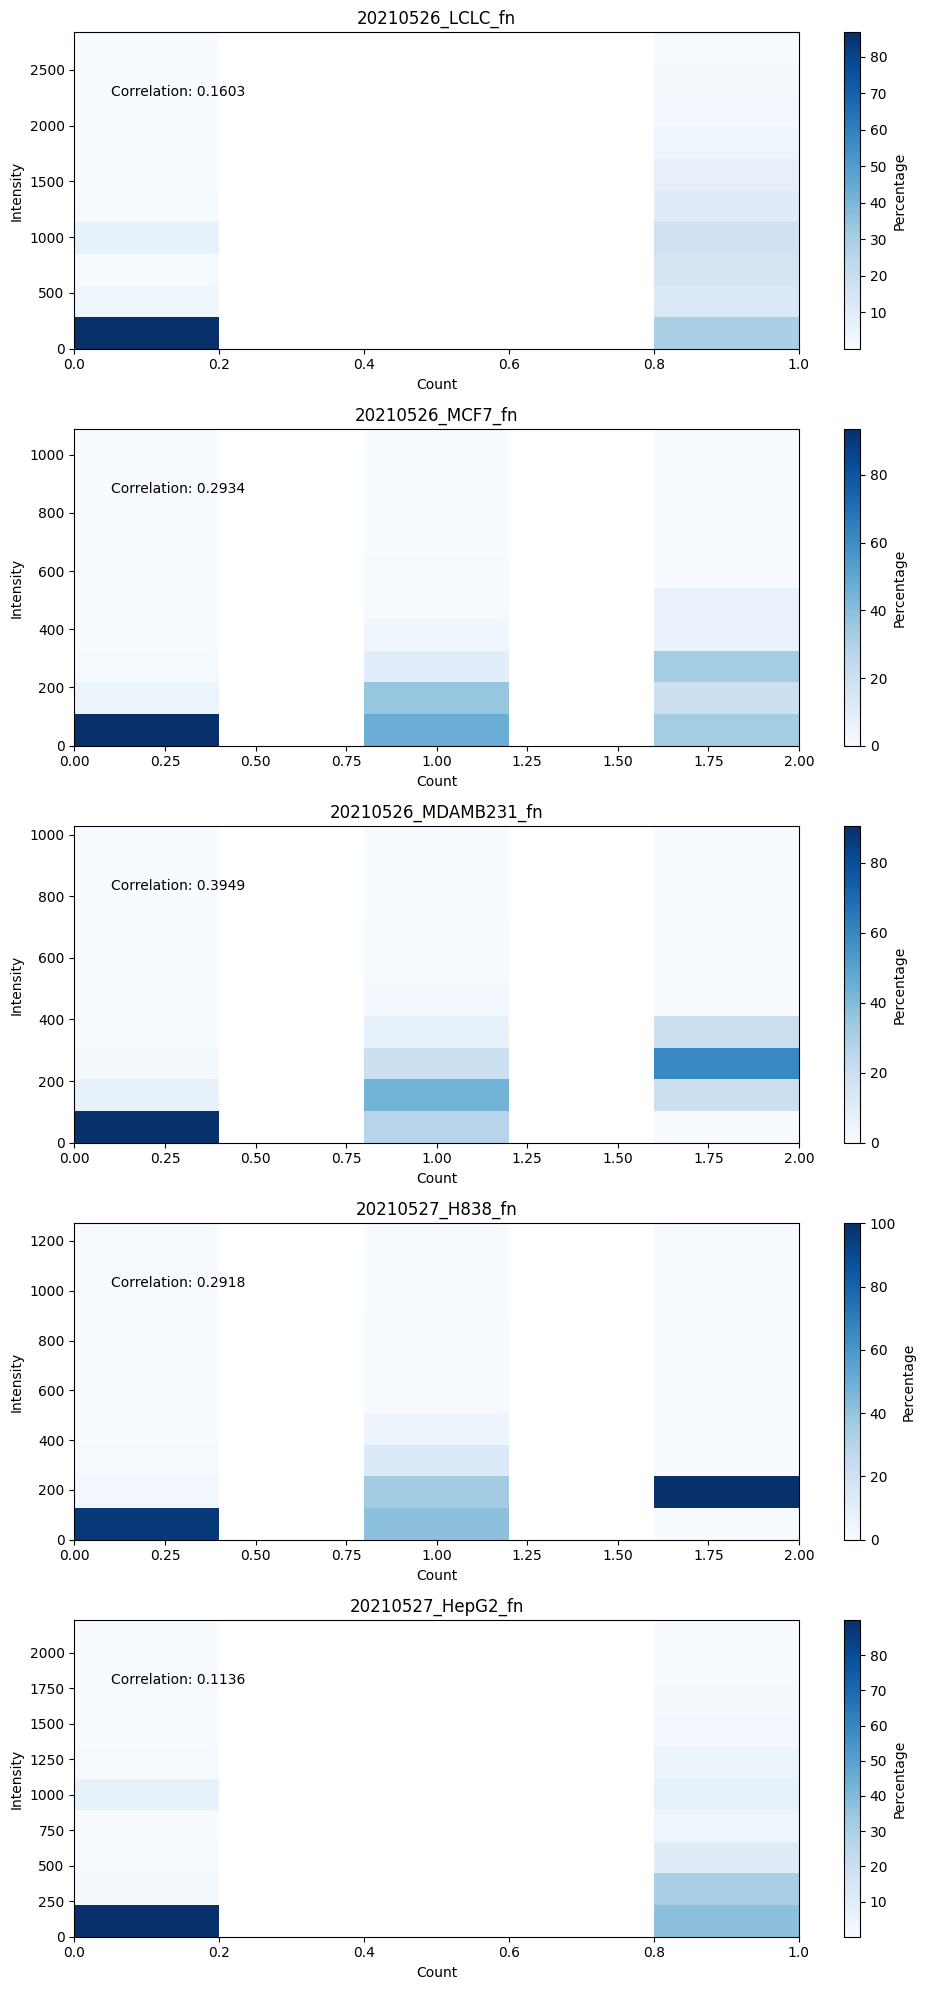

In [2]:
import matplotlib.pyplot as plt
from utils import get_microscope_cell_centroids_mask

fig, ax = plt.subplots(len(dataset_paths), 1, figsize=(10, 20))

for i in range(len(dataset_paths)):
  path = dataset_paths[i]
  dataset = read_dataset(path)
  result = []

  for key in dataset.keys():
    well, mask, scale, tx, ty = dataset[key]
    centroids_mask = get_microscope_cell_centroids_mask(mask)

    for y in range(80):
      for x in range(80):
        x_min, x_max = int(tx + scale * x), int(tx + scale * (x + 1))
        y_min, y_max = int(ty + scale * y), int(ty + scale * (y + 1))

        count = np.count_nonzero(centroids_mask[y_min:y_max, x_min:x_max])
        result.append([count, well[y][x]])

  dataset_name = path.split("/")[-1]
  result = np.array(result)

  counts, x_edges, y_edges = np.histogram2d(result[:, 0], result[:, 1], bins=(5, 10))
  normalized_counts = counts / np.sum(counts, axis=1, keepdims=True) * 100
  x_centers = (x_edges[:-1] + x_edges[1:]) / 2
  y_centers = (y_edges[:-1] + y_edges[1:]) / 2

  correlation = np.corrcoef([result[:, 0], result[:, 1]])[0][1]

  hb = ax[i].pcolormesh(x_centers, y_centers, normalized_counts.T, cmap='Blues')
  cb = fig.colorbar(hb, ax=ax[i])
  cb.set_label("Percentage")

  ax[i].set_xlabel("Count")
  ax[i].set_ylabel("Intensity")
  ax[i].set_title(dataset_name)
  ax[i].annotate(f"Correlation: {format(correlation, '.4f')}", (0.05, 0.8), xycoords='axes fraction')

plt.tight_layout()
plt.show();

# Cell area normalization

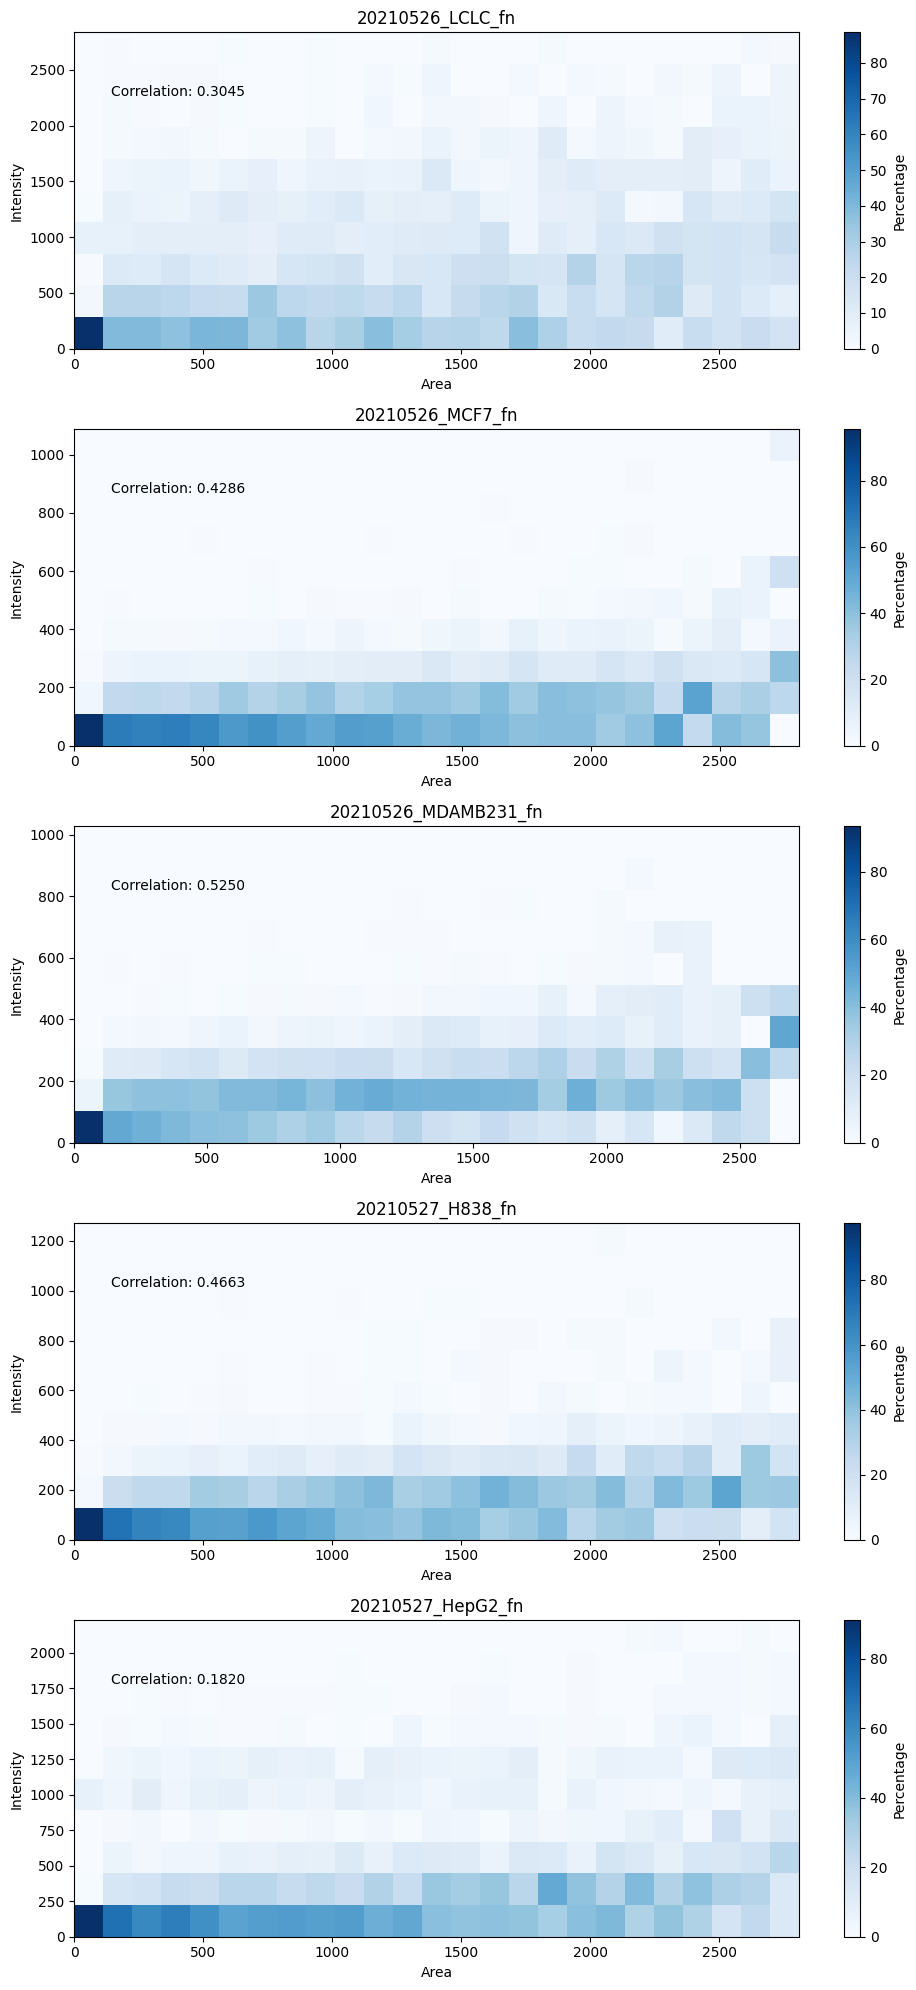

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(dataset_paths), 1, figsize=(10, 20))

for i in range(len(dataset_paths)):
  path = dataset_paths[i]
  dataset = read_dataset(path)
  result = []

  for key in dataset.keys():
    well, mask, scale, tx, ty = dataset[key]

    for y in range(80):
      for x in range(80):
        x_min, x_max = int(tx + scale * x), int(tx + scale * (x + 1))
        y_min, y_max = int(ty + scale * y), int(ty + scale * (y + 1))

        mask_part = mask[y_min:y_max, x_min:x_max]
        area = np.count_nonzero(mask_part)

        result.append([area, well[y][x]])

  dataset_name = path.split("/")[-1]
  result = np.array(result)

  counts, x_edges, y_edges = np.histogram2d(result[:, 0], result[:, 1], bins=(25, 10))
  normalized_counts = counts / np.sum(counts, axis=1, keepdims=True) * 100
  x_centers = (x_edges[:-1] + x_edges[1:]) / 2
  y_centers = (y_edges[:-1] + y_edges[1:]) / 2

  correlation = np.corrcoef([result[:, 0], result[:, 1]])[0][1]

  hb = ax[i].pcolormesh(x_centers, y_centers, normalized_counts.T, cmap='Blues')
  cb = fig.colorbar(hb, ax=ax[i])
  cb.set_label("Percentage")

  ax[i].set_xlabel("Area")
  ax[i].set_ylabel("Intensity")
  ax[i].set_title(path.split("/")[-1])
  ax[i].annotate(f"Correlation: {format(correlation, '.4f')}", (0.05, 0.8), xycoords='axes fraction')

plt.tight_layout()
plt.show();

# Cell distance normalization

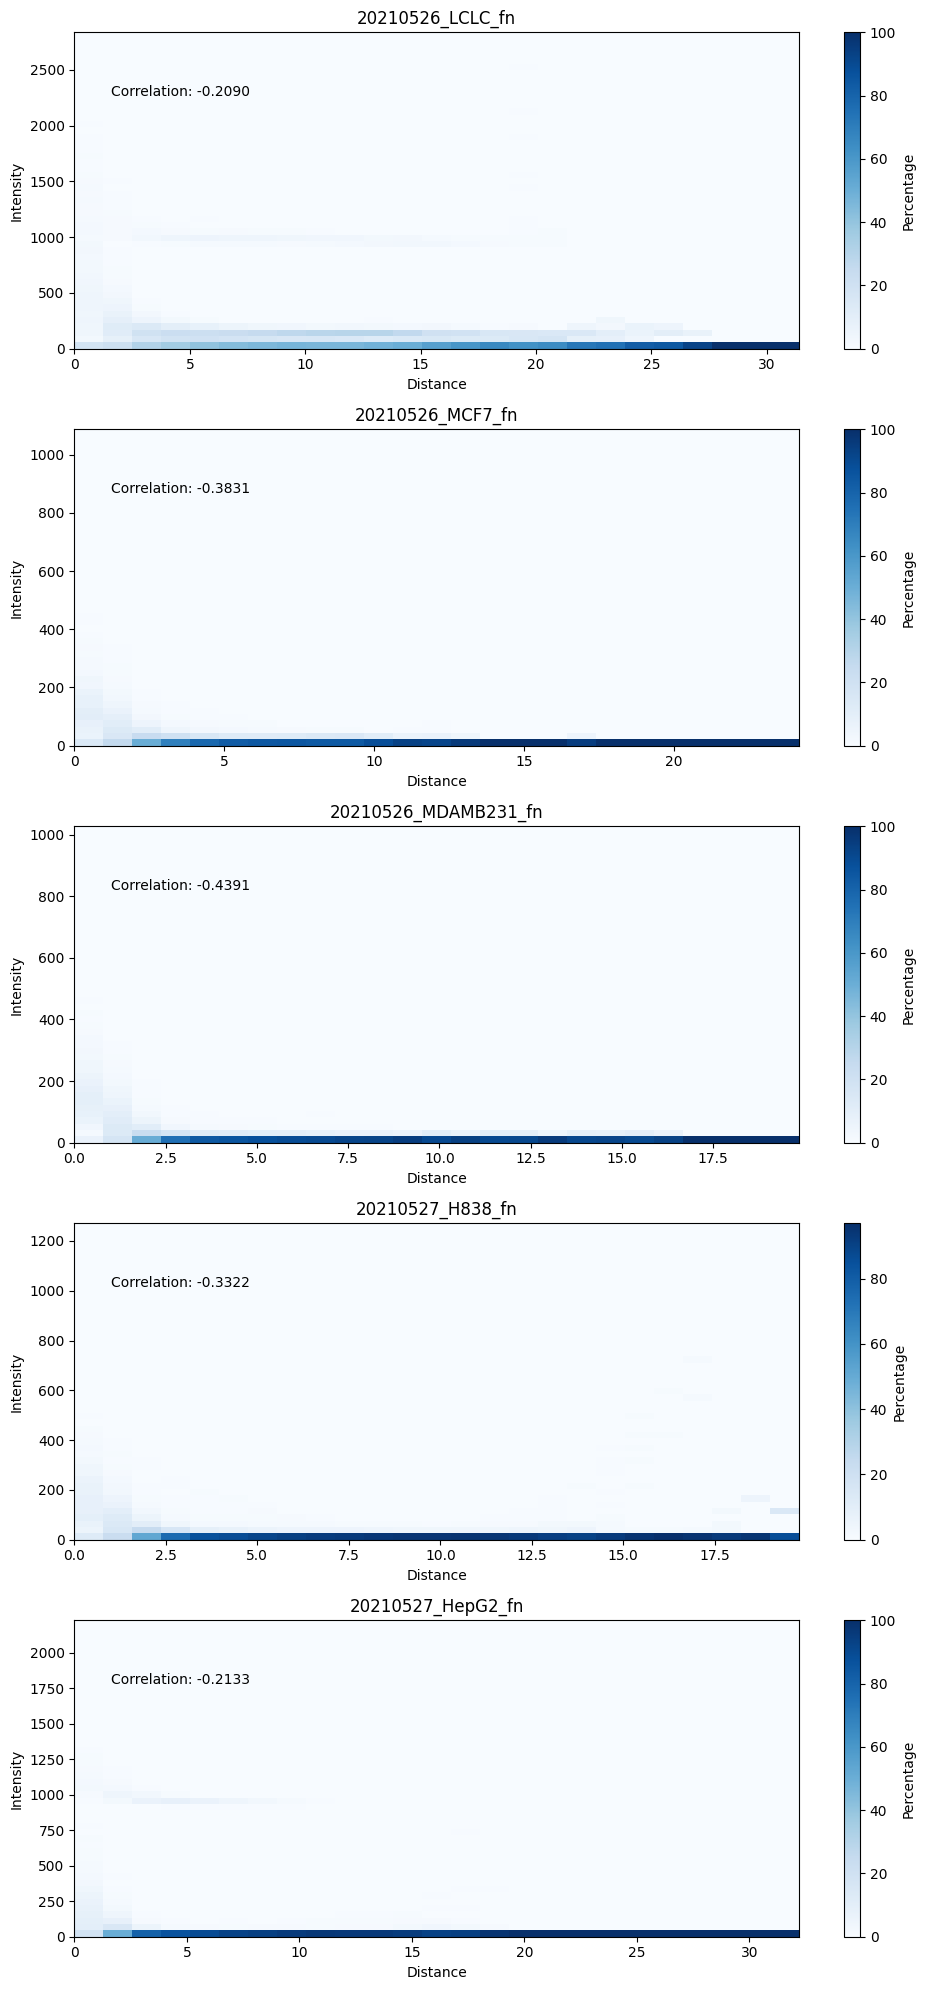

In [6]:
import matplotlib.pyplot as plt
from utils import get_microscope_cell_centroids_mask

fig, ax = plt.subplots(len(dataset_paths), 1, figsize=(10, 20))

for i in range(len(dataset_paths)):
  path = dataset_paths[i]
  dataset = read_dataset(path)
  result = []

  for key in dataset.keys():
    well, mask, scale, tx, ty = dataset[key]
    centroids_mask = get_microscope_cell_centroids_mask(mask)
    well_mask = np.zeros((80, 80))

    for y in range(80):
      for x in range(80):
        x_min, x_max = int(tx + scale * x), int(tx + scale * (x + 1))
        y_min, y_max = int(ty + scale * y), int(ty + scale * (y + 1))

        count = np.count_nonzero(centroids_mask[y_min:y_max, x_min:x_max])
        well_mask[y][x] = count > 0
    
    for y in range(80):
      for x in range(80):
        ones_coords = np.argwhere(well_mask == 1)
        distances = np.linalg.norm(ones_coords - np.array([y, x]), axis=1)
        result.append([np.min(distances), well[y][x]])
    
  dataset_name = path.split("/")[-1]
  result = np.array(result)

  counts, x_edges, y_edges = np.histogram2d(result[:, 0], result[:, 1], bins=(25, 50))
  normalized_counts = counts / np.sum(counts, axis=1, keepdims=True) * 100
  x_centers = (x_edges[:-1] + x_edges[1:]) / 2
  y_centers = (y_edges[:-1] + y_edges[1:]) / 2

  correlation = np.corrcoef([result[:, 0], result[:, 1]])[0][1]

  hb = ax[i].pcolormesh(x_centers, y_centers, normalized_counts.T, cmap='Blues')
  cb = fig.colorbar(hb, ax=ax[i])
  cb.set_label("Percentage")

  ax[i].set_xlabel("Distance")
  ax[i].set_ylabel("Intensity")
  ax[i].set_title(path.split("/")[-1])
  ax[i].annotate(f"Correlation: {format(correlation, '.4f')}", (0.05, 0.8), xycoords='axes fraction')  

plt.tight_layout()
plt.show();